In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import warnings
import sys
sys.path.append("../core")
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
df_training_data  = pd.read_csv('../rsna-2024-lumbar-spine-degenerative-classification/train.csv')
df_training_data_label_co = pd.read_csv("../rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")
df_training_data_description = pd.read_csv("../rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")

In [3]:
df_data = df_training_data_description.merge(df_training_data,on="study_id")

# Visualise distribution 

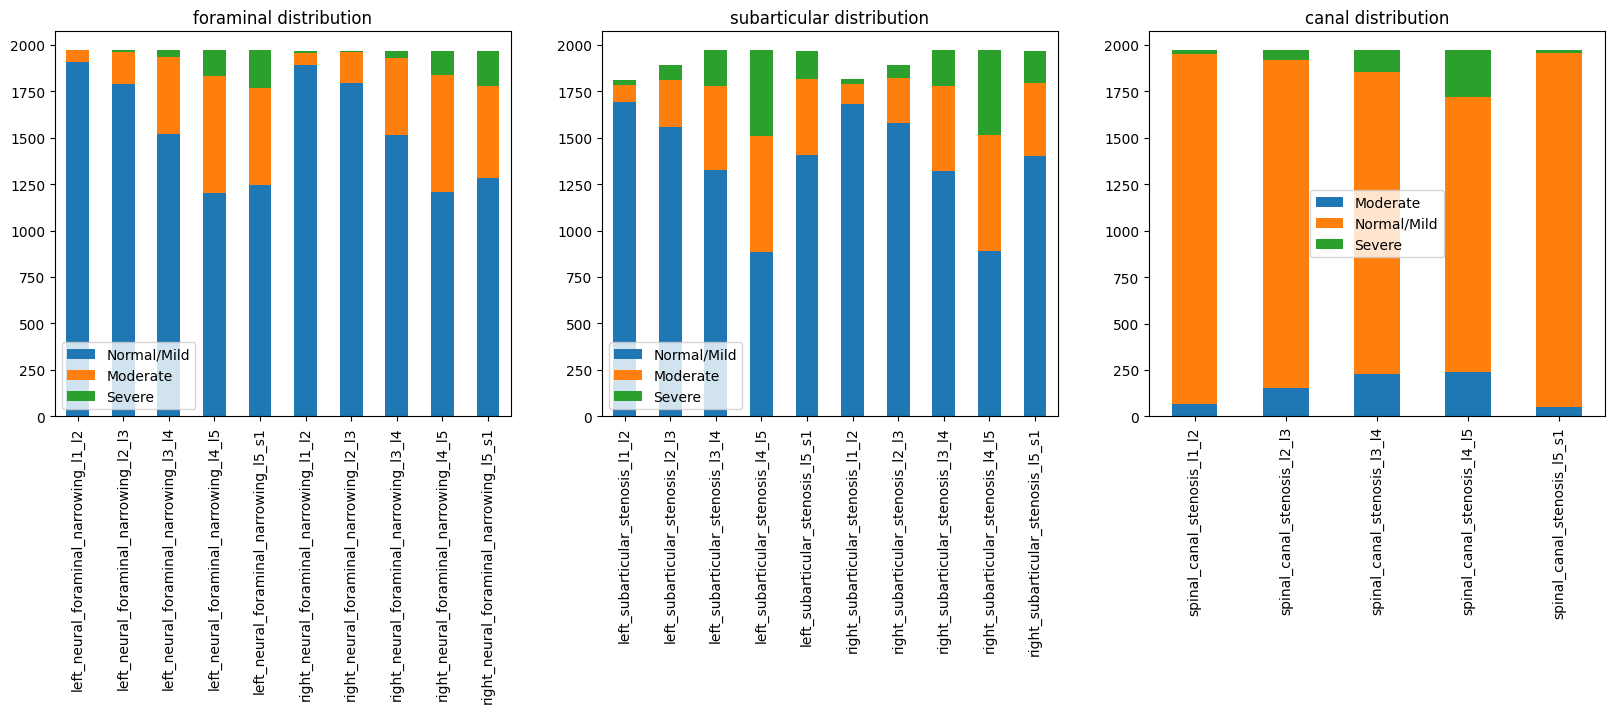

In [4]:
figure, axis = plt.subplots(1,3, figsize=(20,5)) 
for idx, d in enumerate(['foraminal', 'subarticular', 'canal']):
    diagnosis = list(filter(lambda x: x.find(d) > -1, df_training_data.columns))
    dff = df_training_data[diagnosis]
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        value_counts = dff.apply(pd.value_counts).fillna(0).T
    value_counts.plot(kind='bar', stacked=True, ax=axis[idx])
    axis[idx].set_title(f'{d} distribution')

# Load image by patient

In [22]:
import os 
from tqdm import tqdm 
from data_utils import load_by_patient_obj,display_images,display_coor_on_img

In [6]:
all_user_dic = {}
for user in tqdm(df_data.study_id.unique()) :
    user_img = load_by_patient_obj(os.path.join("../rsna-2024-lumbar-spine-degenerative-classification/train_images",str(user)))
    all_user_dic.update({
        user : user_img
    })

100%|██████████| 1975/1975 [01:17<00:00, 25.48it/s]


In [8]:
images_dic = load_by_patient_obj(os.path.join("../rsna-2024-lumbar-spine-degenerative-classification/train_images",str(4003253)))

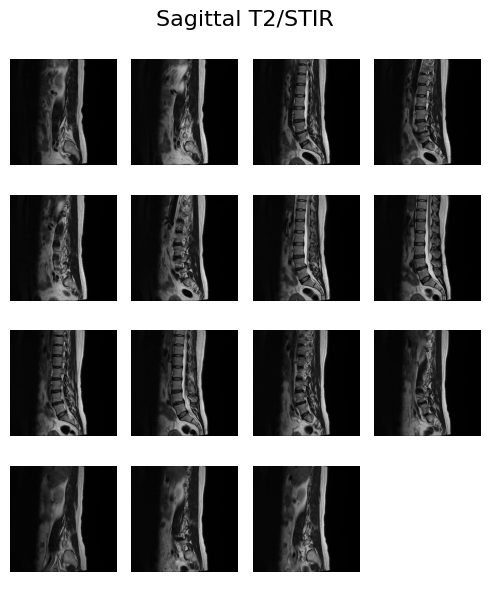

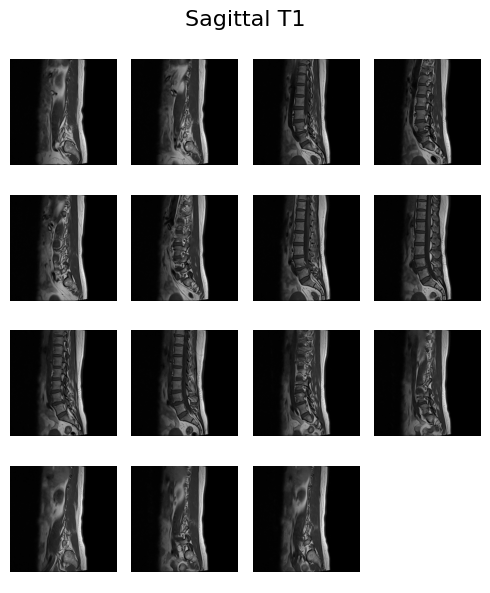

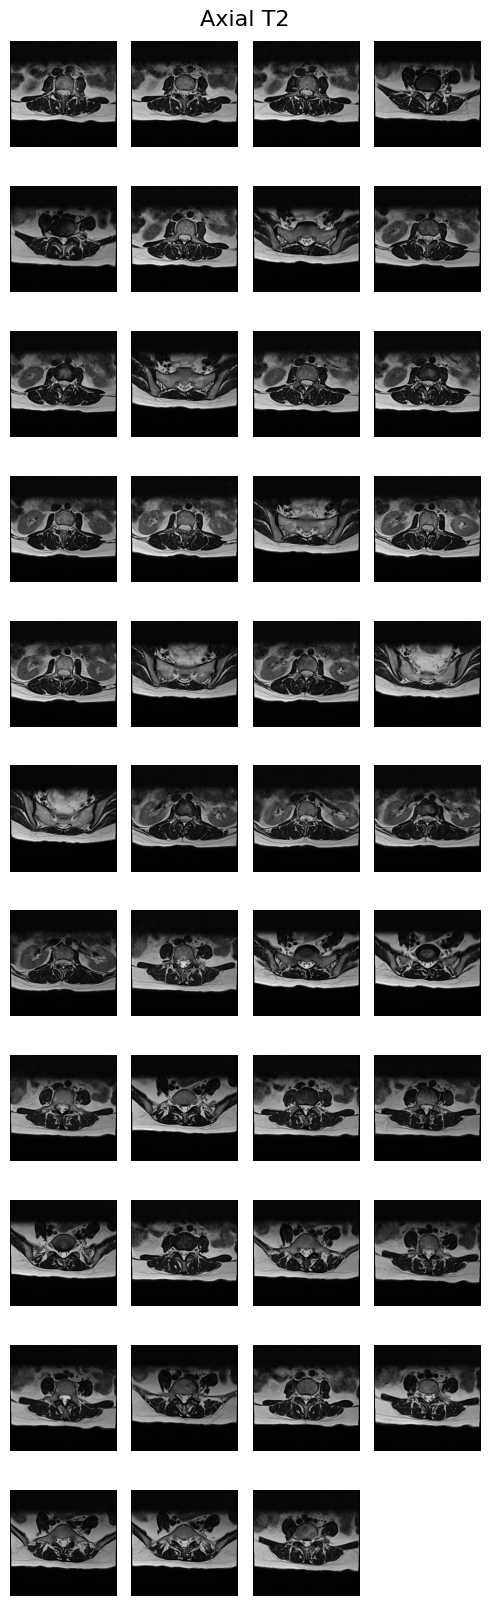

In [9]:
for patient_id in df_data.study_id.unique():
    folders = df_data[df_data["study_id"] == patient_id].series_id.values
    for slicing in folders :
        display_images(
            [images_dic[str(slicing)][i].pixel_array for i in range(len(images_dic[str(slicing)]))],
            df_data[
                    (df_data["study_id"] == patient_id) & (df_data["series_id"] == slicing)
                ].series_description.values[0],
                max_images_per_row=4,

        )
    break

In [11]:
df_training_data_label_co["merge_condition"] = df_training_data_label_co.apply(lambda x : x.condition.lower().replace(" ","_")+"_"+x.level.lower().replace("/","_"),axis=1)

In [12]:
list_of_dfs = []
for patient_id in df_data.study_id.unique():
    for image_id in df_data[df_data["study_id"]==patient_id].series_id.unique() :
        sub_df = pd.DataFrame(df_data[df_data["series_id"]==image_id].T[3:].reset_index().to_numpy(),columns=["merge_condition","State"])
        list_of_dfs.append(df_training_data_label_co[(df_training_data_label_co["study_id"]==patient_id)].merge(sub_df,how="left"))

In [13]:
df_labeled_dataset = pd.concat(list_of_dfs).drop_duplicates()

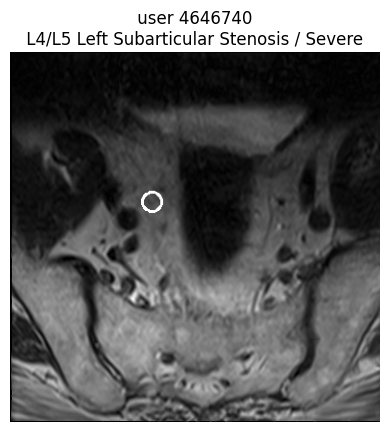

In [39]:
for counter,(i,row) in enumerate(df_labeled_dataset[df_labeled_dataset["State"]=="Severe"].iterrows()):
    image = all_user_dic[row.study_id][str(row.series_id)][row.instance_number].pixel_array
    coo = df_labeled_dataset[df_labeled_dataset["State"]=="Severe"].iloc[i][["x","y"]].to_dict()
    display_coor_on_img(coo, image,title=f" user {row.study_id} \n {row.level} {row.condition} / {row.State} ")
    break